In [ ]:
!pip install gensim
!pip install pyspellchecker

In [ ]:
!pip install -U spacy
!pip install spacy-transformers
!python -m spacy download en_core_web_md

In [4]:
# import modules
import os, os.path
from collections import Counter
import csv

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
from gensim import corpora
from gensim import models

from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

from gensim.models import TfidfModel
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.corpora import Dictionary

import nltk
nltk.download('stopwords')
nltk.download('words')

from spellchecker import SpellChecker

import spacy
import en_core_web_md
from spacy.language import Language

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [75]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [82]:
postings_file = '/content/gdrive/MyDrive/linkedin_dataset/postings/'
resumes_file = '/content/gdrive/MyDrive/linkedin_dataset/resumes/'

# Load Files && Read First Time

## Read Files

In [7]:
'''
For the given path, get the List of all files in the directory tree 
'''
def list_files(dir):
    # create a list of file and sub directories 
    # names in the given directory 
    files_list = os.listdir(dir)
    files = list()
    # Iterate over all the entries
    for entry in files_list:
        # Create full path
        fullPath = os.path.join(dir, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            files = files + list_files(fullPath)
        else:
            files.append(fullPath)
                
    return files

In [80]:
def read_text(fname):
  with open(fname, 'r') as file:
    return ' '.join(file.readlines())  

In [9]:
postings_path = '/content/gdrive/MyDrive/linkedin_dataset/postings/'
postings_files = list_files(postings_path)

resumes_path = '/content/gdrive/MyDrive/linkedin_dataset/resumes/'
resumes_files = list_files(resumes_path)

In [10]:
print('processing %d resumes and %d postings' % (len(resumes_files), len(postings_files)))

processing 97 resumes and 26 postings


In [11]:
def get_label(fname):
  return fname.split('/')[-2]

In [12]:
def read_directories(files):
  dataset = list()
  for f in files:    
    label = get_label(f)
    dataset.append({'label': label, 'data': read_text(f)})
  return dataset

In [13]:
#save content in list of strings
postings = read_directories(postings_files)
resumes = read_directories(resumes_files)

## Preprocessing

In [14]:
nlp_md = en_core_web_md.load()

In [15]:
def remove_ner(text):
  document = nlp_md(text)  
  cleaned_text = []
  ents = [e.text for e in document.ents]

  for item in document:
      if item.text in ents:
          pass
      else:
          cleaned_text.append(item.text)
  return " ".join(cleaned_text)

In [16]:
# remove the contact list from the linkedin resumes
r = list()
for resume in resumes:
  key = resume['label']
  data = resume['data']
  if 'Contacts' in data:
    res = data.split('Contacts')[:-1][0]
  else:
    res = data
  r.append({'label':key, 'data': res})

resumes = r

In [17]:
# Spell checker
spell = SpellChecker()
def correct_spellings(x, spell=spell):
    """correct the missplled words of a given tweet"""
    x = x.split()
    misspelled = spell.unknown(x)
    result = map(lambda word : spell.correction(word) if word in  misspelled else word, x)
    return " ".join(result)
correct_spellings('Nasser Member The Prosecution Public Bathrooms Previous Lawyer Current alhusaini about experience lawyer at Nasser lawo firmi freelance from Dec. 113. to present for')

'Nasser Member The Prosecution Public Bathrooms Previous Lawyer Current alhusaini about experience lawyer at Nasser law firm freelance from Dec. 113. to present for'

In [87]:
# Remove non-English words, and it removes also names and all non dictionary words

def remove_non_english(word):

  words = set(nltk.corpus.words.words())

  removed_non_english = " ".join(w.strip() if w.lower() in words or not w.isalpha() else '' for w in nltk.wordpunct_tokenize(word))

  return ' '.join(removed_non_english.split())

#remove_non_english("nasser عضو النيابة العامة سابق محام حالي alhusaini about experience lawyer at nasser law firm freelance from dec to present for")

In [88]:
remove_non_english("nasser عضو النيابة العامة سابق محام حالي alhusaini about experience lawyer at nasser law firm freelance from dec to present for")

'about experience lawyer at law firm from to present for'

In [19]:
def preprocessing(documents):
  clean_documents = []

  for doc in documents:
    key = doc['label']
    value = doc['data']
    clean = remove_ner(value)
    clean = remove_non_english(clean)    
    clean = ' '.join(simple_preprocess(clean))
    clean_documents.append({'label':key, 'data': correct_spellings(clean)})
  return clean_documents

In [20]:
clean_resumes = preprocessing(resumes)

In [21]:
clean_postings = preprocessing(postings)

In [85]:
clean_resumes

[{'data': 'pimiento experience consultant full time he la de en de eider founder and director full time am the founder of where we seek to share knowledge by of and about specific help and to achieve their professional so that they manage to position themselves as in their of and they can also manage to differentiate from their competence and be chosen without the need to neither resort to advertising nor dominate the new teacher and speaker teacher and speaker in related to digital marketing customer service and customer am teacher in marketing lecture metrics module in the digital marketing certification course workshop on customer service in the digital era and on module in the corporate reputation program la customer service in the digital era consultant and customer service in the digital era take part in the group of where we seek to democratize public and we also seek to achieve that your say about your brand the you dream they say so that you can position your brand reputation 

## Save Files to CSV

In [22]:
def save_documents(documents, fname):
  keys = ['label', 'data']
  with open(fname+'.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(documents)

In [23]:
save_documents(clean_postings, '/content/gdrive/MyDrive/linkedin_dataset/postings')

In [24]:
save_documents(clean_resumes, '/content/gdrive/MyDrive/linkedin_dataset/resumes')

# Load From CSV Files

In [25]:
def read_from_csv(fname):
  
  with open(fname) as f:
    return [{k: v for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True)]

In [26]:
new_resumes = read_from_csv('/content/gdrive/MyDrive/linkedin_dataset/resumes.csv')
new_postings = read_from_csv('/content/gdrive/MyDrive/linkedin_dataset/postings.csv')

In [27]:
new_postings[10].items()

dict_items([('label', 'law'), ('data', 'associate counsel company name company location is one of the most active global early stage venture capital our mission is to uplift people and around the world through since our inception in we have in over across our plus team are in more than to support global portfolio notable include credit karma grab and we also help develop innovation by supporting and through accelerator and educational and through with and around the world the role we have new opening for lawyer to join our global legal team and advise on legal in the region specifically covering the kingdom of and in this role you will work at the forefront of the most exciting global venture and technological and will be to assess legal and provide creative and pragmatic you should be willing and able to work on wide variety of have the ability to provide commercial and practical legal advice and education to our global team we work at an incredible pace so you will need to be self st

# Dataset Preparation

In [28]:
def create_training_corpus(documents):
  training_corpus = np.empty(len(documents), dtype=object)
  i = 0
  for doc in documents: 
    data = doc['data'].split()
    label = doc['label']
    tagged_doc = TaggedDocument(data, [label, i]) 
    training_corpus[i] = tagged_doc
    i += 1
  return training_corpus

In [29]:
postings_corpus = create_training_corpus(new_postings)
resumes_corpus = create_training_corpus(new_resumes)

In [30]:
general_corpus = np.empty(len(postings_corpus) + len(resumes_corpus), dtype=object)
correct_labels = list()
i = 0
for doc in postings_corpus:
  general_corpus[i] = doc  
  i +=1

for doc in resumes_corpus:
  general_corpus[i] = doc  
  i +=1

In [31]:
def manage_word_frequencies(corpus):    
  word_corpus = []
  for doc in corpus:  
    new_doc = []
    counter = Counter(doc.words)

    for word in counter:
      freq = counter[word]
      if freq >= 2:
        for i in range(freq):
          new_doc.append(word)
    word_corpus.append(new_doc)
  return word_corpus

In [32]:
general_word_corpus = manage_word_frequencies(general_corpus)
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in general_word_corpus]

correct_labels = [doc.tags[0] for doc in general_corpus]

print(BoW_corpus)
print(correct_labels)

[[(0, 2), (1, 2), (2, 23), (3, 4), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 3), (11, 2), (12, 2), (13, 6), (14, 2), (15, 5), (16, 2), (17, 2), (18, 4), (19, 6), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 9), (26, 2), (27, 7), (28, 4), (29, 2), (30, 2), (31, 5), (32, 2), (33, 15), (34, 11), (35, 3), (36, 4), (37, 3), (38, 2), (39, 3)], [(1, 5), (2, 31), (3, 3), (7, 2), (10, 3), (11, 4), (12, 3), (13, 5), (15, 14), (16, 2), (18, 6), (25, 8), (26, 10), (27, 9), (28, 5), (30, 8), (33, 11), (34, 16), (37, 5), (40, 2), (41, 4), (42, 3), (43, 3), (44, 2), (45, 3), (46, 2), (47, 2), (48, 2), (49, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 2), (55, 2), (56, 2), (57, 2), (58, 2), (59, 2), (60, 4), (61, 3), (62, 2), (63, 2), (64, 2), (65, 4), (66, 2), (67, 3), (68, 3), (69, 5), (70, 2), (71, 2), (72, 3), (73, 2)], [(1, 4), (2, 22), (7, 4), (10, 2), (12, 4), (14, 2), (15, 3), (17, 2), (18, 2), (19, 2), (25, 10), (26, 2), (27, 4), (30, 3), (33, 11), (34, 9), (37, 4), (52, 3), (

In [33]:
id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
print(id_words)

[[('according', 2), ('all', 2), ('and', 23), ('as', 4), ('category', 2), ('complete', 2), ('education', 2), ('ensure', 2), ('equivalent', 2), ('essential', 2), ('experience', 3), ('food', 2), ('for', 2), ('guest', 6), ('hotel', 2), ('in', 5), ('information', 2), ('is', 2), ('job', 4), ('knowledge', 6), ('maintain', 2), ('make', 2), ('maximum', 2), ('menu', 2), ('name', 2), ('of', 9), ('on', 2), ('or', 7), ('restaurant', 4), ('seat', 2), ('service', 2), ('set', 5), ('table', 2), ('the', 15), ('to', 11), ('up', 3), ('while', 4), ('with', 3), ('work', 2), ('working', 3)], [('all', 5), ('and', 31), ('as', 3), ('ensure', 2), ('experience', 3), ('food', 4), ('for', 3), ('guest', 5), ('in', 14), ('information', 2), ('job', 6), ('of', 8), ('on', 10), ('or', 9), ('restaurant', 5), ('service', 8), ('the', 11), ('to', 16), ('with', 5), ('absence', 2), ('an', 4), ('any', 3), ('are', 3), ('area', 2), ('basis', 3), ('beverage', 2), ('by', 2), ('culinary', 2), ('customer', 2), ('day', 2), ('during', 

In [34]:
words = [dictionary[i] for i in range(len(dictionary))]
print("number of unique words in dataset postings and resumes, vocabulary", len(words))

number of unique words in dataset postings and resumes, vocabulary 948


### Visualize Corpus (Word Clouds)

In [35]:
postings = ' '.join(' '.join(simple_preprocess(remove_stopwords(post['data']))) for post in new_postings)
resumes = ' '.join(' '.join(simple_preprocess(remove_stopwords(resume['data']))) for resume in new_resumes)

In [36]:
from wordcloud import WordCloud
# Function to create a word cloud object from the corpus with the color map as passed
def generateWordCloud(corpus: str, cmap: str):    
    wordcloud = WordCloud(background_color = 'white', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

    wordcloud.generate(corpus)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

    return wordcloud

### Postings Words Cloud

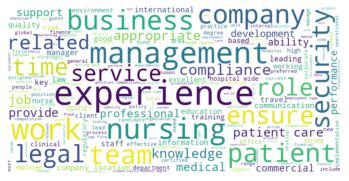

<Figure size 432x288 with 0 Axes>

In [37]:
# Generate the Word Clouds for each of the Corpuses and save them as a PNG file
generateWordCloud(corpus = postings, cmap = 'viridis') #tab20b, Accent

### Resumes Word Cloud

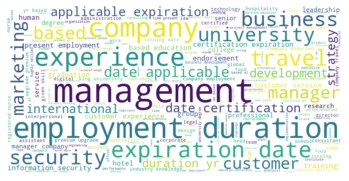

<Figure size 432x288 with 0 Axes>

In [38]:
generateWordCloud(corpus = resumes, cmap = 'viridis')

# Doc2Vec Experiments

In [39]:
tags_profile = dict()

for doc in general_corpus:
  tag = doc.tags[0]
  if tag not in tags_profile:
    tags_profile[tag] = []
  tags_profile[tag].append(doc)

In [40]:
train_corpus = []
test_corpus = []

for tag in tags_profile:
  number = len(tags_profile[tag])

  for i in range(int(0.8 * number)):
    train_corpus.append(tags_profile[tag][i])
  for i in range(int(0.8 * number), number):
    test_corpus.append(tags_profile[tag][i])

In [41]:
doc2vec_model = Doc2Vec(vector_size=300, epochs=100)
doc2vec_model.build_vocab(train_corpus)
doc2vec_model.train(train_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
def test(corpus, model):
  count = len(corpus)
  correct = 0
  for i in range(count):    
    test_doc= corpus[i]
    correct_label = test_doc.tags[0]
    test_vector = model.infer_vector(test_doc.words, steps = 50)
    inferred_label, _ = model.docvecs.most_similar([test_vector])[0]
    if inferred_label == correct_label:
      correct += 1
  return correct/count

In [43]:
result = 0
for i in range(5):
  r = test(test_corpus, doc2vec_model)
  print('test (', i+1, '): ', r)
  result += r

print('Average result', result/5)

test ( 1 ):  0.8571428571428571
test ( 2 ):  0.8571428571428571
test ( 3 ):  0.8571428571428571
test ( 4 ):  0.8571428571428571
test ( 5 ):  0.8214285714285714
Average result 0.85


# Word Embeddings

## Finding Word Embeddings

In [44]:
# process a sentence using the model
dev_doc = nlp_md("python code")
bio_doc = nlp_md("python snake")

# Get the mean vector for the entire sentence (useful for sentence classification etc.)
print('its not contextualised ', dev_doc[0].vector[0], bio_doc[0].vector[0])

its not contextualised  0.035414 0.035414


In [45]:
def get_embedding(word):
  return nlp_md(word)[0].vector
get_embedding('book');

In [46]:
word_embeddings = dict()
for word in words:
  word_embeddings[word] = get_embedding(word)

In [47]:
embeddings = list(word_embeddings.values())

# Word Embedding Clustering

In [48]:
np_embeddings = np.array(embeddings)

In [49]:
def clusters_profile(clusters, w_clusters):
  i = 0
  for cluster in clusters:    
    print(i, len(clusters[i]), w_clusters[i])
    i += 1

## Embeddings Clustering

In [50]:
n_clust = 30
kmeans_embeddings = KMeans(n_clusters=n_clust, random_state=0).fit(np_embeddings)

In [51]:
predicted_word_labels = kmeans_embeddings.predict(np_embeddings)
labels_set = set(predicted_word_labels)

clusters = [[] for i in labels_set]
w_clusters = [[] for i in labels_set]

word_labels = dict()
for i, label in enumerate(predicted_word_labels):
  clusters[label].append(embeddings[i])
  w_clusters[label].append(words[i])  
  word_labels[words[i]] = label

In [52]:
clusters_profile(clusters, w_clusters)

0 31 ['hospitality', 'support', 'organize', 'opportunity', 'project', 'supporting', 'award', 'organization', 'candidate', 'join', 'seeking', 'representative', 'meet', 'liaison', 'participate', 'commission', 'speaker', 'group', 'member', 'endorsed', 'council', 'volunteer', 'endorsement', 'community', 'honor', 'program', 'ministry', 'organized', 'committee', 'advisory', 'board']
1 66 ['according', 'as', 'is', 'name', 'or', 'an', 'are', 'by', 'met', 'that', 'action', 'other', 'also', 'be', 'act', 'most', 'should', 'specifically', 'written', 'alongside', 'been', 'both', 'permanently', 'term', 'well', 'which', 'widely', 'only', 'opinion', 'novel', 'who', 'being', 'not', 'various', 'given', 'lead', 'least', 'must', 'directed', 'charge', 'immediately', 'promptly', 'regularly', 'upon', 'label', 'may', 'normally', 'works', 'was', 'included', 'issuing', 'such', 'speaking', 'imam', 'highly', 'present', 'handled', 'none', 'wound', 'several', 'employed', 'different', 'statement', 'closely', 'letter

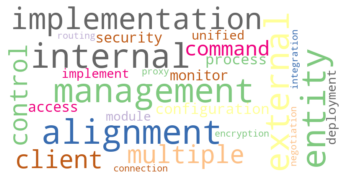

<Figure size 432x288 with 0 Axes>

In [53]:
generateWordCloud(' '.join(w_clusters[23]), 'Accent')

In [54]:
def holistic_clustering(np_embeddings, words, n_clusters, max_iter):  
  kmeans_embeddings = KMeans(n_clusters=n_clusters, random_state=0, max_iter=max_iter).fit(np_embeddings)

  labels = kmeans_embeddings.predict(np_embeddings)
  labels_set = set(labels)

  clusters = [[] for i in labels_set]
  w_clusters = [[] for i in labels_set]

  word_labels = dict()
  for i, label in enumerate(labels):
    clusters[label].append(embeddings[i])
    w_clusters[label].append(words[i])  
    word_labels[words[i]] = label
  
  return clusters, w_clusters, word_labels, labels_set

# TFIDF with Clustered Embeddings

#### Combine terms & Clustering Documents

In [55]:
def plain_tfidf(BoW_corpus):
  tfidf_model = models.TfidfModel(BoW_corpus, smartirs='ntc')
    
  tfidf_list = list()
  
  for doc in BoW_corpus:
    doc_tfidf = np.zeros(len(dictionary))    
    for id, freq in tfidf_model[doc]:
      doc_tfidf[id] = freq
    tfidf_list.append(doc_tfidf)
  return tfidf_list

In [56]:
def clustered_tfidf(BoW_corpus, dictionary, labels_set, word_labels):
  tfidf_model = models.TfidfModel(BoW_corpus, smartirs='ntc')
  tfidf_list = list()
  for doc in BoW_corpus:
    doc_tfidf = dict()
    for id, freq in tfidf_model[doc]:
      doc_tfidf[dictionary[id]] = np.around(freq, decimals=2)
    tfidf_list.append(doc_tfidf)

  docs_list = []
  vector_list = []

  for doc in tfidf_list:
    tf_idf = dict()
    
    for lab in labels_set:
      tf_idf[lab]  = 0
      
    for word in doc:        
      term = doc[word]
      label = word_labels[word]    
      tf_idf[label] += float(term)
    vector_list.append(list(tf_idf.values()))
    docs_list.append(tf_idf)
  return vector_list, docs_list

In [57]:
n_words = len(words)
n_docs = len(correct_labels)
n_labels = len(set(correct_labels))

print('number of unique words', n_words, 'number of documents', n_docs, 'number of categories', n_labels)

number of unique words 948 number of documents 123 number of categories 8


In [58]:
label_code = {"human_resources": 0, "nursing":1, "law":2, "travel":3, "restaurant":4,"pharmacist":5,"customer_service":6,"security":7}
code_label = {0: "human_resources", 1: "nursing", 2:"law", 3:"travel", 4:"restaurant", 5:"pharmacist", 6:"customer_service", 7:"security"}

In [59]:
encoded_correct_labels = [label_code[lab] for lab in correct_labels]

In [60]:
vector_list, docs_list = clustered_tfidf(BoW_corpus, dictionary, labels_set, word_labels)
kmeans_tfidf = KMeans(n_clusters=n_labels, random_state=0).fit(vector_list)
predicted_labels = kmeans_tfidf.predict(vector_list)

In [61]:
def evaluation(predicted_labels):
  return adjusted_rand_score(encoded_correct_labels, predicted_labels)

In [64]:
evaluation(predicted_labels)

0.20753039593129827

### Holistic Clustering Approach

In [63]:
max = 0
max_clusters = 0

n_words = len(words)
for n_cluster in range(40, 75, 1):  
  clusters, w_clusters, word_labels, labels_set = holistic_clustering(embeddings, words, n_cluster, 300)  
  vector_list, docs_list = clustered_tfidf(BoW_corpus, dictionary, labels_set, word_labels)
  kmeans_tfidf = KMeans(n_clusters=n_labels, random_state=0, max_iter=300).fit(vector_list)
  predicted_labels = kmeans_tfidf.predict(vector_list)
  rand = evaluation(predicted_labels)
  
  if rand > max:
    max = rand
    max_clusters = n_cluster
    
    print('now best clustering got ', max, ' rand score with ', max_clusters, ' clusters')

now best clustering got  0.17797903495565384  rand score with  40  clusters
now best clustering got  0.2499838485563502  rand score with  43  clusters
now best clustering got  0.3164310000566514  rand score with  46  clusters


# Classification 

## Classifiying Using Plain tf-idf


In [65]:
vector_list = plain_tfidf(BoW_corpus)

In [66]:
# Spliting into X & y
X = vector_list
y = encoded_correct_labels

# Splitting into training & test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 0)

# Training the classifier & predicting on test data
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [67]:
print('Accuracy: ', accuracy_score(y_test, y_pred) * 100, '%')

Accuracy:  72.0 %


In [68]:
print('\nClassification Report')
clf_report = classification_report(y_test, y_pred)
print('======================================================')
print('\n', clf_report)


Classification Report

               precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.33      0.50         3
           2       1.00      0.40      0.57         5
           3       0.75      1.00      0.86         3
           4       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1

    accuracy                           0.72        25
   macro avg       0.79      0.68      0.68        25
weighted avg       0.79      0.72      0.69        25



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


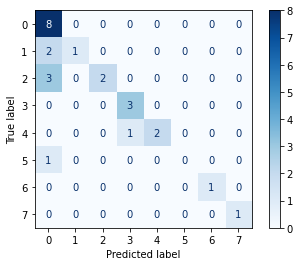

In [69]:
plot_confusion_matrix(classifier, X_test, y_test, cmap='Blues');

## Classifying Using Clustered tf-idf

In [70]:
# Best Number of Clusters for Words
n_clusters = 50

In [71]:
#Holistic Clustering for Words
clusters, w_clusters, word_labels, labels_set = holistic_clustering(embeddings, words, n_clusters, 300)
vector_list, _ = clustered_tfidf(BoW_corpus, dictionary, labels_set, word_labels)

# Training the classifier, predicting on test data & evaluating performance with classification metrics
# Spliting into X & y
X = vector_list
y = encoded_correct_labels

# Splitting into training & test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Training the classifier & predicting on test data
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [72]:
print('Accuracy: ', accuracy_score(y_test, y_pred) * 100, '%')

Accuracy:  92.0 %


In [73]:
print('\nClassification Report')
clf_report = classification_report(y_test, y_pred)
print('======================================================')
print('\n', clf_report)


Classification Report

               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       0.75      1.00      0.86         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1

    accuracy                           0.92        25
   macro avg       0.95      0.93      0.94        25
weighted avg       0.93      0.92      0.92        25



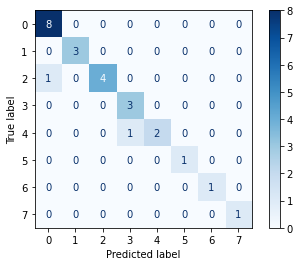

In [74]:
plot_confusion_matrix(classifier, X_test, y_test, cmap='Blues');